In [1]:
# All imports


from __future__ import print_function, division

#!pip install monai
import matplotlib.pyplot as plt
import numpy as np
import glob


import SimpleITK as sitk
import pandas as pd
import glob
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans

import csv
from scipy import ndimage, misc
from tqdm import tqdm

import numba
from numba import njit, prange

import os
import skimage.io as io
import skimage.transform as trans
import numpy as np

import scipy
from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu
import matplotlib.patches as patches

import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')
import copy


import os
import glob
import uuid
import numpy as np


import numpy
import warnings

import functools
import pickle
import time


import numpy as np

import argparse
import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable

import torch.nn as nn

from ipywidgets import IntProgress
#from ipywidgets import IProgress
# [STAR] All imports for DBT

import os
import pandas
%matplotlib inline
import matplotlib.pyplot as plt
from duke_dbt_data import dcmread_image, read_boxes, draw_box, evaluate
np.random.seed(0)
#torch.manual_seed(0)!pip install monai

# [STAR] All the Imports

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from pathlib import Path
import ast
import pandas as pd
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import re
import cv2

import random

In [ ]:
# [STAR] Read all the slices in training set without augmentation

basepath = '/home/drilnvm/DBTex/'
df = read_boxes(boxes_fp=basepath+"BCS-DBT-boxes-train.csv", filepaths_fp=basepath+"BCS-DBT-file-paths-train.csv")


trainx = []
trainy = []
boximage  = []
coordx =  []
coordy = []

width_arr = []
height_arr = []

for i in tqdm(range(224)):
    box_series  = df.iloc[i]
    view        = box_series["View"]
    slice_index = box_series["Slice"]
    image_path  = os.path.join(basepath, box_series["descriptive_path"])
    image       = dcmread_image(fp=image_path, view=view, index=slice_index)
    
    trainx.append(image)
    trainy.append(box_series["Class"])
    
    x, y, width, height = box_series[["X", "Y", "Width", "Height"]]
    
    coordx.append(x)
    coordy.append(y)
    width_arr.append(width)
    height_arr.append(height)

print(len(trainx), len(trainy), len(boximage))



np.save('coordx.npy', coordx)
np.save('coordy.npy', coordy)

newtrainx  = np.zeros([len(trainx), 1, 3000, 2000], 'float16')
newtrainy  = np.zeros([len(trainx), 1], 'float16')
for i in range(len(trainx)):
    newtrainx[i, 0, :trainx[i].shape[0], :trainx[i].shape[1]] = trainx[i]
    if trainy[i] == 'benign':
        newtrainy[i, 0] = 0
    else:
        newtrainy[i, 0] = 1

np.save('trainx.npy', newtrainx)
np.save('trainy.npy', newtrainy)

In [511]:
# [STAR] For downsampling the image

# trainx = np.load('trainx_m2.npy')
# print(trainx.shape)
# trainxd = []
# for idx in tqdm(range(trainx.shape[0])):
#     img = trainx[idx, 0].astype('float32')/60000.0
#     img[img > 1] = 1
#     img = ndimage.interpolation.zoom(img, 0.25, order=3)
#     trainxd.append(img)
# trainxd = np.array(trainxd).astype('float16')
np.save('trainxd_m2.npy', trainxd)
print(trainxd.shape)

(224, 750, 500)


In [181]:
# [STAR] DBT classes for data loader

class DBTDataset(torch.utils.data.Dataset):
    def __init__(self, train_set = 1, transforms = None):
        super().__init__()
        
        suffix_str  = ''#random.choice(['_m2', '_m1', '_p1', '_p2', ''])
        print('READING NEW FILE >> ', suffix_str, ' <<')
        
        #shuffle_index = np.arange(224)
        #np.random.shuffle(shuffle_index)
        #np.save('shuffle_array.npy', shuffle_index)
        #shuffle_index = np.load('shuffle_array.npy')
        
        trainx  = np.load('trainxd.npy')
        trainx2 = np.load('trainxd_p1.npy')
        trainx1 = np.load('trainxd_m1.npy')
        
        trainx4 = np.load('trainxd_p2.npy')
        trainx3 = np.load('trainxd_m2.npy')
        
        # [1, 0, 2], [3,1,0], [0, 2, 4]
        trainy = np.load('trainy'+suffix_str+'.npy')
        coordx = np.load('coordx'+suffix_str+'.npy')
        coordy = np.load('coordy'+suffix_str+'.npy')
        width_arr  = np.load('width_arr'+suffix_str+'.npy')
        height_arr = np.load('height_arr'+suffix_str+'.npy')
        
        self.counter = 0
        if train_set == 1:
            self.train_start  = 0
            self.train_end    = 175
        else:
            self.train_start  = 175
            self.train_end    = 224
        
        self.train_set = train_set
        #t1 = np.load('trainx_m1.npy')[self.train_start:self.train_end]
        #t2 = np.load('trainx.npy')[self.train_start:self.train_end]
        #t3 = np.load('trainx_p1.npy')[self.train_start:self.train_end]
        #self.trainx  =  np.concatenate([t2, t1, t3], axis=1)
        
        self.trainx1     = trainx1[self.train_start:self.train_end]
        self.trainx2     = trainx2[self.train_start:self.train_end]
        self.trainx3     = trainx3[self.train_start:self.train_end]
        self.trainx4     = trainx4[self.train_start:self.train_end]
        self.trainx      = trainx[self.train_start:self.train_end]
        
        self.trainy     = trainy[self.train_start:self.train_end]
        self.coordx     = coordx[self.train_start:self.train_end]
        self.coordy     = coordy[self.train_start:self.train_end]
        self.width_arr  = width_arr[self.train_start:self.train_end]
        self.height_arr = height_arr[self.train_start:self.train_end]
        
        print('Train size are ', self.trainx1.shape, self.trainx2.shape, self.trainx.shape, self.width_arr.shape)
        
        if self.train_set == 1:
        #if 0:
            self.trainx  = np.concatenate([self.trainx,  self.trainx1, self.trainx2], axis=0)
            self.trainx1 = np.concatenate([self.trainx1, self.trainx3, self.trainx],  axis=0)
            self.trainx2 = np.concatenate([self.trainx2, self.trainx,  self.trainx4], axis=0)
            
            self.trainy = np.concatenate([self.trainy, self.trainy, self.trainy], axis=0)
            self.coordx = np.concatenate([self.coordx, self.coordx, self.coordx], axis=0)
            self.coordy = np.concatenate([self.coordy, self.coordy, self.coordy], axis=0)
            self.width_arr  = np.concatenate([self.width_arr,  self.width_arr, self.width_arr], axis=0)
            self.height_arr = np.concatenate([self.height_arr, self.height_arr, self.height_arr], axis=0)
        
        self.scaling_factor = 0.25
        
        print('Total size of dataset ', self.trainx.shape)
#         self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx.npy')[self.train_start:self.train_end]#.astype('float16')/60000.0
#         self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy.npy')[self.train_start:self.train_end]
#         self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx.npy')[self.train_start:self.train_end]
#         self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy.npy')[self.train_start:self.train_end]
#         self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr.npy')[self.train_start:self.train_end]
#         self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr.npy')[self.train_start:self.train_end]
        
        # A.Rotate(limit=15, interpolation=3, border_mode=4, always_apply=False, p=0.5)
        self.transforms1 = A.Compose(#A.RandomScale(interpolation=3, p=0.5),
                                    [A.HorizontalFlip(p=0.5),  
                                     A.VerticalFlip(p=0.5), 
                                     A.RandomScale(interpolation=3, scale_limit=0.2, p=0.75),
                                     A.Rotate(limit=25, interpolation=3, border_mode=4, always_apply=False, p=0.75),],
                                     #A.Downscale(scale_min=0.95, scale_max=0.98, p=0.25, interpolation=3),],
                                    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
                                   )
        
    def __getitem__(self, idx):
        self.counter = self.counter+1
        #if self.counter % 10 == 0:
        #    print('Counter is ', self.counter)
        
#         if self.train_set == 1 and self.counter % 150 == 0 and random.random() < 0.2:
#             suffix_str  = random.choice([ '_m1', '_p1', ''])
#             print('READING NEW FILE >> ', suffix_str, ' <<')
#             self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx'+suffix_str+'.npy')[self.train_start:self.train_end]#.astype('float16')/60000.0
#             self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr'+suffix_str+'.npy')[self.train_start:self.train_end]
                
        #img = self.trainx[idx].astype('float32')/60000.0
        img  = self.trainx[idx].astype('float32')#/60000.0
        img1 = self.trainx1[idx].astype('float32')
        img2 = self.trainx2[idx].astype('float32')
        
        #img[img > 1] = 1
        #img = ndimage.interpolation.zoom(img, self.scaling_factor)
        img  = np.expand_dims(img,  0)
        img1 = np.expand_dims(img1, 0)
        img2 = np.expand_dims(img2, 0)
        
        img = np.concatenate([img1, img, img2], axis=0)
        #img = np.concatenate([img, img, img], axis=0)
        
        if(self.train_set == 1):
            img = np.moveaxis(img, 0, -1)
        
        boxes = np.array([self.coordx[idx]*self.scaling_factor, self.coordy[idx]*self.scaling_factor, self.width_arr[idx]*self.scaling_factor, self.height_arr[idx]*self.scaling_factor])#records[['x', 'y', 'w', 'h']].values
        boxes = np.expand_dims(boxes, axis=0)
        boxes[:, 2] = boxes[:, 0]+boxes[:, 2]
        boxes[:, 3] = boxes[:, 1]+boxes[:, 3]
        
        #print('width and height are  ', idx, self.width_arr[idx], self.height_arr[idx])
        area = self.width_arr[idx] * self.height_arr[idx]
        #print('areas is ', area)
        area = torch.Tensor(area)
        
        # there is only one class
        labels =  torch.ones((1,)).type(torch.int64)
        
        if(self.train_set == 1):
        #if(0):
            transformed = self.transforms1(image=img, bboxes=boxes, labels=labels)
            image    = transformed['image']
            boxes    = np.array(transformed['bboxes'])
            img      = np.moveaxis(image, 2, 0)
            
            #print('boxes shape is ', boxes.shape, len(boxes.shape))
            if len(boxes.shape) < 2:
                return None
        
        # suppose all instances are not crowd
        iscrowd = torch.Tensor(np.array([0])).type(torch.int64)
        
        target              = {}
        target['boxes']     = torch.Tensor(boxes)
        target['labels']    = labels
        target['image_id']  = torch.tensor([idx])
        target['area']      = area
        target['iscrowd']   = iscrowd
        
        return img, target, idx
    
    def __len__(self):
        return self.trainx.shape[0]

class DBTDatasetAdd(torch.utils.data.Dataset):
    def __init__(self, train_set = 1, transforms = None):
        super().__init__()
        
        suffix_str  = ''
        trainx  = np.load('trainxd.npy')
        trainx2 = np.load('trainxd_p1.npy')
        trainx1 = np.load('trainxd_m1.npy')
        
        trainy = np.ones(len(trainx))#np.load('trainy'+suffix_str+'.npy')
        coordx = np.load('coordx'+suffix_str+'.npy')
        coordy = np.load('coordy'+suffix_str+'.npy')
        width_arr  = np.load('width_arr'+suffix_str+'.npy')
        height_arr = np.load('height_arr'+suffix_str+'.npy')
        
        self.counter = 0
        if train_set == 1:
            self.train_start  = 0
            self.train_end    = 175
        else:
            self.train_start  = 175
            self.train_end    = 224
        
        self.train_set   = train_set
        self.trainx1     = trainx1[self.train_start:self.train_end]
        self.trainx2     = trainx2[self.train_start:self.train_end]
        self.trainx      = trainx[self.train_start:self.train_end]
        
        self.trainy     = trainy[self.train_start:self.train_end]
        self.coordx     = coordx[self.train_start:self.train_end]
        self.coordy     = coordy[self.train_start:self.train_end]
        self.width_arr  = width_arr[self.train_start:self.train_end]
        self.height_arr = height_arr[self.train_start:self.train_end]
        
        print('Train size are ', self.trainx1.shape, self.trainx2.shape, self.trainx.shape, self.trainy.shape)
        
        if self.train_set == 1:
            self.trainx = np.concatenate([self.trainx, self.trainx1, self.trainx2], axis=0)
            self.trainy = np.concatenate([self.trainy, self.trainy, self.trainy], axis=0)
            self.coordx = np.concatenate([self.coordx, self.coordx, self.coordx], axis=0)
            self.coordy = np.concatenate([self.coordy, self.coordy, self.coordy], axis=0)
            self.width_arr  = np.concatenate([self.width_arr,  self.width_arr, self.width_arr], axis=0)
            self.height_arr = np.concatenate([self.height_arr, self.height_arr, self.height_arr], axis=0)
            
            trainx_add = np.load('trainx_add.npy')
            coordx_add = np.load('coordx_add.npy').astype('int64')
            coordy_add = np.load('coordy_add.npy').astype('int64')
            width_arr_add  = np.load('width_arr_add.npy').astype('int64')
            height_arr_add = np.load('height_arr_add.npy').astype('int64')
            trainy_add     = np.zeros(len(trainx_add))#*2
            
            self.trainy = np.concatenate([np.ones(len(self.trainx)), trainy_add], axis=0)
            self.trainx = np.concatenate([self.trainx, trainx_add], axis=0)
            self.coordx = np.concatenate([self.coordx, coordx_add], axis=0)
            self.coordy = np.concatenate([self.coordy, coordy_add], axis=0)
            self.width_arr  = np.concatenate([self.width_arr,   width_arr_add], axis=0)
            self.height_arr = np.concatenate([self.height_arr, height_arr_add], axis=0)
            
        
        print('Train Labels are ', self.trainy)
        print('Train size are ', self.coordx.shape, self.width_arr.shape, self.trainy.shape)
        
        self.scaling_factor = 0.25
        
        print('Total size of dataset ', self.trainx.shape)        
        self.transforms1 = A.Compose(
                                    [A.HorizontalFlip(p=0.5),  A.VerticalFlip(p=0.5),], 
                                     #A.Downscale(scale_min=0.95, scale_max=0.98, p=0.25, interpolation=3),],
                                    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
                                   )
        
    def __getitem__(self, idx):
        self.counter = self.counter+1
        img          = self.trainx[idx].astype('float32')
        #img1 = self.trainx1[idx].astype('float32')
        #img2 = self.trainx2[idx].astype('float32')
        #img[img > 1] = 1
        #img = ndimage.interpolation.zoom(img, self.scaling_factor)
        img  = np.expand_dims(img, 0)
        #img1 = np.expand_dims(img1, 0)
        #img2 = np.expand_dims(img2, 0)
        
        #img = np.concatenate([img1, img, img2], axis=0)
        img = np.concatenate([img, img, img], axis=0)
        
        if(self.train_set == 1):
            img = np.moveaxis(img, 0, -1)
        
        boxes = np.array([self.coordx[idx]*self.scaling_factor, self.coordy[idx]*self.scaling_factor, self.width_arr[idx]*self.scaling_factor, self.height_arr[idx]*self.scaling_factor])#records[['x', 'y', 'w', 'h']].values
        boxes = np.expand_dims(boxes, axis=0)
        boxes[:, 2] = boxes[:, 0]+boxes[:, 2]
        boxes[:, 3] = boxes[:, 1]+boxes[:, 3]
        
        #print('width and height are  ', idx, self.width_arr[idx], self.height_arr[idx])
        area = int(self.width_arr[idx] * self.height_arr[idx])
        #print('areas is ', area)
        area = torch.Tensor(area)
        
        # there is only one class
        #print('Label is ', self.trainy[idx])
        #if self.trainy[idx] == 2:
         #   print('Label is two 2')
        
        labels =  torch.Tensor((self.trainy[idx],)).type(torch.int64) #torch.ones((1,)).type(torch.int64)
        #print('labels are ', labels)
        if(self.train_set == 1):
        #if(0):
            transformed = self.transforms1(image=img, bboxes=boxes, labels=labels)
            image    = transformed['image']
            boxes    = np.array(transformed['bboxes'])
            img      = np.moveaxis(image, 2, 0)
        
        # suppose all instances are not crowd
        iscrowd = torch.Tensor(np.array([0])).type(torch.int64)
        
        target              = {}
        target['boxes']     = torch.Tensor(boxes)
        target['labels']    = labels
        target['image_id']  = torch.tensor([idx])
        target['area']      = area
        target['iscrowd']   = iscrowd
        
        return img, target, idx
    
    def __len__(self):
        return self.trainx.shape[0]

class DBTDatasetValidation(torch.utils.data.Dataset):
    def __init__(self, val_index = 0, transforms = None):
        super().__init__()
        
        self.basepath  = '/home/drilnvm/DBTex/'
        self.counter   = 0
        self.val_index = val_index
        #self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-train.csv')
        self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-validation.csv')
        
        box_series       = self.df.iloc[self.val_index]
        self.PatientID   = box_series["PatientID"]
        self.StudyUID    = box_series["StudyUID"]
        self.view        = box_series["View"]
        
        image_path      = os.path.join(self.basepath, box_series["descriptive_path"])
        self.vol        = dcmread_image(fp=image_path, view=self.view)
        self.newtrainx  = np.zeros([len(self.vol), 1, 3000, 2000], 'float16')
        for i in range(len(self.vol)):
            self.newtrainx[i, 0, :self.vol[i].shape[0], :self.vol[i].shape[1]] = self.vol[i]
        
        print('File reading done ', self.vol.shape, image_path)
        #print()
        
    def __getitem__(self, idx):
        
        img          = self.newtrainx[idx, 0].astype('float32')/60000.0
        img[img > 1] = 1
        img = ndimage.interpolation.zoom(img, 0.25)
        img = np.expand_dims(img, 0)
        img = np.concatenate([img, img, img], axis=0)
        
        target              = {}
        target['image_id']  = torch.tensor([idx])
        
        return img, target, idx
    
    def __len__(self):
        return self.vol.shape[0]

class DBTDatasetValidationTrain(torch.utils.data.Dataset):
    def __init__(self, val_index = 0, transforms = None):
        super().__init__()
        
        self.basepath  = '/home/drilnvm/DBTex/'
        self.counter   = 0
        self.val_index = val_index
        #self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-boxes-validation.csv')
        #self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-boxes-train.csv')
        #self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-train.csv')
        self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-test.csv')
        
        box_series       = self.df.iloc[self.val_index]
        self.PatientID   = box_series["PatientID"]
        self.StudyUID    = box_series["StudyUID"]
        self.view        = box_series["View"]
        if(0):
            self.slice_index = box_series["Slice"]
            self.X           = box_series["X"]
            self.Y           = box_series["Y"]
            self.Width       = box_series["Width"]
            self.Height      = box_series["Height"]
        #Slice,X,Y,Width,Height
        
        #image_path      = os.path.join(self.basepath, box_series["descriptive_path"])
        self.vol = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy/'+self.PatientID+'_'+self.StudyUID+'_'+self.view+'.npy')
        #self.vol        = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy1/val_vol_'+str(val_index)+'.npy')#dcmread_image(fp=image_path, view=self.view)
        self.newtrainx  = np.expand_dims(self.vol, 1)#np.zeros([len(self.vol), 1, 750, 500], 'float16')
        print('File reading done ',            self.vol.shape)
        
    def __getitem__(self, idx):
        img          = self.newtrainx[idx, 0].astype('float32')#/60000.0
        img[img > 1] = 1
        #img = ndimage.interpolation.zoom(img, 0.25)
        img = np.expand_dims(img, 0)
        if idx == 0 or idx == self.vol.shape[0]-1:
            img = np.concatenate([img, img, img], axis=0)
        else:
            img1 = self.newtrainx[idx-1, 0].astype('float32')
            img1[img1 > 1] = 1
            img1 = np.expand_dims(img1, 0)
            
            img2 = self.newtrainx[idx+1, 0].astype('float32')
            img2[img2 > 1] = 1
            img2 = np.expand_dims(img2, 0)
            
            img  = np.concatenate([img1, img, img2], axis=0)
        
        target              = {}
        #if idx == self.slice_index:
        #    target['boxes']  = torch.tensor([self.X, self.Y, self.X+self.Width, self.Y+self.Height])
        
        return img, target, idx
    
    def __len__(self):
        return self.vol.shape[0]

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [78]:
# [STAR] For extracting the 3D lesion locations

basepath  = '/home/drilnvm/DBTex/'
df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-boxes-train.csv')

all_lesions = []
non_lesions = []
non_lesions_per_vol_count = 5

for val_index in tqdm(range(224)):
    box_series  = df.iloc[val_index]
    PatientID   = box_series["PatientID"]
    StudyUID    = box_series["StudyUID"]
    view        = box_series["View"]
    
    slice_index = box_series["Slice"]
    X           = box_series["X"]
    Y           = box_series["Y"]
    Width       = box_series["Width"]
    Height      = box_series["Height"]
    
    vol = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy/'+PatientID+'_'+StudyUID+'_'+view+'.npy')
    
    temp  = np.array([X, Y, Width, Height])/4.0#all_target[up_90[slice_index][0]]
    temp  = temp.astype('int')
    
    midx = (temp[1] + temp[1]+temp[3])//2
    midy = (temp[0] + temp[0]+temp[2])//2

    lesion_size = 32
    z_depth     = 8
    lesion      = vol[slice_index-z_depth:slice_index+z_depth, midx-lesion_size:midx+lesion_size, midy-lesion_size:midy+lesion_size]
    
    lesion_count = 0
    
    while(lesion_count < non_lesions_per_vol_count):
        tx = random.randint(0, vol.shape[1])
        ty = random.randint(0, vol.shape[2])
        tz = random.randint(0, vol.shape[0])
        
        non_lesion = vol[tz-z_depth:tz+z_depth, tx-lesion_size:tx+lesion_size, ty-lesion_size:ty+lesion_size]
        if np.count_nonzero(non_lesion.flatten())/(16*32*32.0) > 0.75:
            non_lesions.append(non_lesion)
            lesion_count =  lesion_count+1
        else:
            continue
    
    all_lesions.append(lesion)
    print(len(all_lesions), len(non_lesions))

print(len(all_lesions))

  2%|▏         | 4/224 [00:00<00:06, 33.24it/s]

1 0
2 0
3 0
4 0
5 0
6 0
7 0


  5%|▍         | 11/224 [00:00<00:06, 31.22it/s]

8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0


  9%|▉         | 20/224 [00:00<00:07, 28.43it/s]

17 0
18 0
19 0
20 0
21 0


 12%|█▏        | 26/224 [00:00<00:08, 24.25it/s]

22 0
23 0
24 0
25 0
26 0


 13%|█▎        | 29/224 [00:01<00:08, 24.15it/s]

27 0
28 0
29 0
30 0
31 0
32 0
33 0


 17%|█▋        | 38/224 [00:01<00:06, 28.85it/s]

34 0
35 0
36 0
37 0
38 0
39 0


 20%|██        | 45/224 [00:01<00:06, 28.33it/s]

40 0
41 0
42 0
43 0
44 0
45 0
46 0


 23%|██▎       | 51/224 [00:01<00:06, 28.28it/s]

47 0
48 0
49 0
50 0
51 0
52 0


 26%|██▌       | 58/224 [00:01<00:05, 28.92it/s]

53 0
54 0
55 0
56 0
57 0
58 0


 29%|██▉       | 66/224 [00:02<00:05, 30.44it/s]

59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0


 31%|███▏      | 70/224 [00:02<00:05, 29.64it/s]

67 0
68 0
69 0
70 0
71 0
72 0


 35%|███▍      | 78/224 [00:02<00:05, 28.94it/s]

73 0
74 0
75 0
76 0
77 0
78 0


 37%|███▋      | 82/224 [00:02<00:04, 30.29it/s]

79 0
80 0
81 0
82 0
83 0
84 0
85 0


 40%|████      | 90/224 [00:03<00:04, 29.32it/s]

86 0
87 0
88 0
89 0
90 0
91 0


 43%|████▎     | 96/224 [00:03<00:04, 28.49it/s]

92 0
93 0
94 0
95 0
96 0
97 0


 46%|████▌     | 102/224 [00:03<00:04, 25.27it/s]

98 0
99 0
100 0
101 0
102 0


 46%|████▋     | 104/224 [00:03<00:04, 28.38it/s]

103 0
104 0


KeyboardInterrupt: 

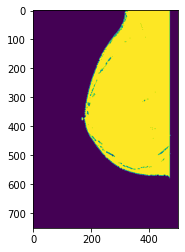

In [77]:
#print(vol.shape)
#plt.imshow(vol[32].astype('float32'))
temp = vol[32] > 0
#plt.hist(vol[32].flatten())
plt.imshow(temp)

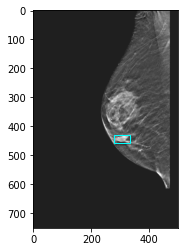

[279 431  54  26]


In [18]:
#slice_index = random.randint(0, len(up_90)-1)

plt.imshow(vol[slice_index].astype('float32'), cmap='gray')
ax    = plt.gca()

temp  = np.array([X, Y, Width, Height])/4.0#all_target[up_90[slice_index][0]]
temp = temp.astype('int')
index = 0

rect  = patches.Rectangle((temp[0], temp[1]), temp[2], temp[3], linewidth=1, edgecolor='cyan', fill = False)
ax.add_patch(rect)

plt.show()

print(temp)

163


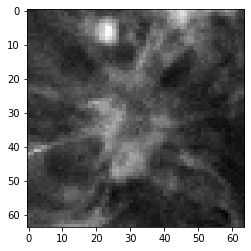

In [73]:
index = random.randint(0, len(all_lesions)-1)
print(index)
img   = all_lesions[index][8]
plt.imshow(img.astype('float32'), cmap='gray')

In [63]:
# [STAR] DBT Dataset and Model Creation ResNet50

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    #return torch.utils.data.dataloader.default_collate(batch)
    return tuple(zip(*batch))

train_dataset     = DBTDataset(train_set=1)
valid_dataset     = DBTDataset(train_set=0)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=6,
    shuffle=True,
    num_workers=0, collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0, collate_fn=collate_fn
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, trainable_backbone_layers=3)
#model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
#model       = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

params       = [p for p in model.parameters() if p.requires_grad]
#optimizer    = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0001)
optimizer    = torch.optim.RMSprop(params, lr=0.00001, weight_decay=0.001)
lmbda        = lambda epoch: 0.95
lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

#lr_scheduler = None

READING NEW FILE >>    <<
Train size are  (175, 750, 500) (175, 750, 500) (175, 750, 500) (175,)
Total size of dataset  (525, 750, 500)
READING NEW FILE >>    <<
Train size are  (49, 750, 500) (49, 750, 500) (49, 750, 500) (49,)
Total size of dataset  (49, 750, 500)


In [ ]:
# [STAR] Training loop for DBT dataset

loss_hist    = Averager()

loss_object  = Averager()
loss_box_reg = Averager()
loss_rpn_box_reg = Averager()
loss_classifier  = Averager()

val_loss_hist    = Averager()
val_loss_object  = Averager()
val_loss_box_reg = Averager()
val_loss_rpn_box_reg = Averager()
val_loss_classifier  = Averager()

prev_min   = 1000
num_epochs = 50
itr        = 1
for epoch in range(num_epochs):
    loss_hist.reset()
    loss_object.reset()
    loss_box_reg.reset()
    loss_rpn_box_reg.reset()
    loss_classifier.reset()
        
    model.train()
    
    for images, targets, image_ids in train_data_loader:
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))
        
        images    = new_images
        targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        
        loss_object.send(loss_dict['loss_objectness'].item())
        loss_box_reg.send(loss_dict['loss_box_reg'].item())
        loss_rpn_box_reg.send(loss_dict['loss_rpn_box_reg'].item())
        loss_classifier.send(loss_dict['loss_classifier'].item())
                
        losses     = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
        
    if 1:#itr % 31 == 0:
        #print('itr is ', itr)
        val_loss_hist.reset()
        val_loss_object.reset()
        val_loss_box_reg.reset()
        val_loss_rpn_box_reg.reset()
        val_loss_classifier.reset()

        with torch.no_grad():
            for images, targets, image_ids in valid_data_loader:
                new_images  = []
                for img in images:
                    new_images.append(torch.Tensor(img).to(device))

                images    = new_images
                targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
                loss_dict = model(images, targets)

                losses     = sum(loss for loss in loss_dict.values())
                loss_value = losses.item()

                val_loss_hist.send(loss_value)
                val_loss_object.send(loss_dict['loss_objectness'].item())
                val_loss_box_reg.send(loss_dict['loss_box_reg'].item())
                val_loss_rpn_box_reg.send(loss_dict['loss_rpn_box_reg'].item())
                val_loss_classifier.send(loss_dict['loss_classifier'].item())
        
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    torch.save(model.state_dict(), 'fasterrcnn_resnet50_dbt41_'+str(epoch)+'.pth')
    print(f"Epoch #{epoch} Train loss: {round(loss_hist.value, 5)} {round(loss_object.value, 5)} {round(loss_box_reg.value, 5)} {round(loss_rpn_box_reg.value, 5)} {round(loss_classifier.value, 5)}")
    print(f"Epoch #{epoch} Val   loss: {round(val_loss_hist.value, 5)} {round(val_loss_object.value, 5)} {round(val_loss_rpn_box_reg.value, 5)} {round(val_loss_box_reg.value, 5)} {round(val_loss_classifier.value, 5)}")

In [ ]:
# [STAR] For Obtaining the result (ResNet) on Validation set of the Challenge

def collate_fn(batch):
    return tuple(zip(*batch))

device      = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)
#model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt25.pth'))
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt40_4.pth'))
model.eval()


trainx = []
trainy = []
boximage  = []
coordx =  []
coordy = []

width_arr  = []
height_arr = []

PatientID_arr = []
StudyUID_arr  = []

#device = torch.device("cpu")
#model.to(device)


import pickle

#shuffle_index = np.load('shuffle_array.npy')
#shuffle_index = shuffle_index[150:]
        
basepath = '/home/drilnvm/DBTex/'
#df = read_boxes(boxes_fp=basepath+"BCS-DBT-boxes-train.csv", filepaths_fp=basepath+"BCS-DBT-file-paths-train.csv")
df = pd.read_csv(basepath+"BCS-DBT-file-paths-test.csv")
#df = pd.read_csv(basepath+"BCS-DBT-boxes-train.csv")

for i in tqdm(range(0, len(df))):
#for i in tqdm(range(0, 49)):
#for i in tqdm(range(175, 224)):
    #if i in shuffle_index:
    
    #else:
    #    continue
    box_series  = df.iloc[i]
    PatientID   = box_series["PatientID"]
    StudyUID    = box_series["StudyUID"]
    view        = box_series["View"]
    
    print('Processing ', i, PatientID, StudyUID, view)
    
    valid_dataset     = DBTDatasetValidationTrain(val_index=i)
    #valid_dataset     = DBTDataset(train_set=0)
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0, 
        collate_fn=collate_fn
    )
        
    all_target = []
    all_scores = []
    all_images = []
    
    for images, targets, image_ids in valid_data_loader:
        #print(targets)
        all_images.append(images[0][0].astype('float16'))
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))

        images    = new_images
        #targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model.forward(images)
        #print(loss_dict)
        
        all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
        all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())
    
    with open('/media/drilnvm/ubuntudata2/DBTEx_results40_4_validation/'+PatientID+'_'+StudyUID+'_'+view+'_score.data', 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(all_scores, filehandle)
    
    with open('/media/drilnvm/ubuntudata2/DBTEx_results40_4_validation/'+PatientID+'_'+StudyUID+'_'+view+'_target.data', 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(all_target, filehandle)
    
    #np.save('/media/drilnvm/ubuntudata2/DBTEx_numpy2/val_vol_'+str(i), np.array(all_images).astype('float16'))

In [ ]:
# [STAR] For plotting the result for a given volume

df = pd.read_csv(basepath+"BCS-DBT-labels-train.csv")

if 0:
    while(True):    
        i  = random.randint(0, len(df))
        PatientID  = df.iloc[i].PatientID
        StudyUID   = df.iloc[i].StudyUID
        view_name  = df.iloc[i].View
        if df.iloc[i].Normal:
            break

case_index = i
print(case_index, PatientID, StudyUID, view_name, df.iloc[i].Normal)
vol = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy/'+PatientID+'_'+StudyUID+'_'+view_name+'.npy')
#print(vol.shape)

all_target = pickle.load(open('/media/drilnvm/ubuntudata2/DBTEx_results27H_validation/'+PatientID+'_'+StudyUID+'_'+view_name+'_target.data', 'rb'))
all_scores = pickle.load(open('/media/drilnvm/ubuntudata2/DBTEx_results27H_validation/'+PatientID+'_'+StudyUID+'_'+view_name+'_score.data', 'rb'))

print(vol.shape, len(all_target), len(all_scores))

up_90 = []
for ik, k in enumerate(all_scores):
    if len(k) > 0 and k[0] > 0.7:
        up_90.append((ik, k[0]))

img         = vol.astype('float32')

print(len(up_90), up_90)

plt.figure(figsize=(15,7))
if len(up_90) > 0:
    slice_index = random.randint(0, len(up_90)-1)

    print(up_90[slice_index])
    plt.imshow(img[up_90[slice_index][0]], cmap='gray')
    ax    = plt.gca()

    temp  = all_target[up_90[slice_index][0]]
    index = 0

    rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
    ax.add_patch(rect)

    plt.show()
else:
    print("Not found ")

In [184]:
# [STAR] For writing the csv file for submission

foldername= 'DBTEx_results35_14_validation'

from scipy.signal import find_peaks

total_prediction = ["PatientID,StudyUID,View,X,Width,Y,Height,Z,Depth,Score"]
prediction_lines = []

df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-test.csv')
#df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-train.csv')
#df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-boxes-train.csv')
print('Total length ', len(df))


all1_array      = []
all_peaks_array = []
names_array     = []

def smooth(y, box_pts):
    box      = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

error_count = 0

#for case_index in range(175, 224):
#for case_index in range(0, 49):
for case_index in range(len(df)):
    #if case_index not in shuffle_index:
    #    continue
    
    box_series  = df.iloc[case_index]
    PatientID   = box_series["PatientID"]
    StudyUID    = box_series["StudyUID"]
    view_name   = box_series["View"]
    
    names_array.append(PatientID+'_'+StudyUID+'_'+view_name)
    #img        = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy1/val_vol_'+str(case_index)+'.npy')
    all_target = pickle.load(open('/media/drilnvm/ubuntudata2/'+foldername+'/'+PatientID+'_'+StudyUID+'_'+view_name+'_target.data', 'rb'))
    all_scores = pickle.load(open('/media/drilnvm/ubuntudata2/'+foldername+'/'+PatientID+'_'+StudyUID+'_'+view_name+'_score.data', 'rb'))
    
    print(len(all_target))
    print(len(all_scores))
    print('--------------------------')
    #print(PatientID, StudyUID, view_name,  len(all_target), len(all_scores))
    
    d_init_x = -1
    d_init_y = -1
    d_init_z = -1
    all1     = []
    
    for i, t in enumerate(all_scores):
        if len(t) > 0:# and t[0] > 0.05:
            if d_init_x == -1:
                d_init_x = all_target[i][0][0]
                d_init_y = all_target[i][0][1]
                d_init_z = i
            
            temp_dist = np.linalg.norm([all_target[i][0][0]-d_init_x, all_target[i][0][1]-d_init_y, i-d_init_z])
            #all1.append(temp_dist)
            if temp_dist < 10:
                all1.append(all_scores[i][0])
            else:
                all1.append(0)
            
            # update previous coordinate
            d_init_x = all_target[i][0][0]
            d_init_y = all_target[i][0][1]
            d_init_z = i
        else:
            all1.append(0)
    
    #all1     = 1-np.array(all1)
    all1     = np.array(all1)
    all1     = smooth(all1, 3)
    #all1[all1 < 0.3] = 0
    #peaks, _ = find_peaks(all1, width=2)
    peaks, _ = find_peaks(all1)#, distance=4)
    
    all1_array.append(all1)
    all_peaks_array.append(peaks)
    
    #peaks, _ = find_peaks(all1, distance=4, plateau_size=4)
    
    volume_predictions = []
    for p in peaks:
        if len(all_target[p]) == 0:
            if len(all_target[p-1]) > 0 or len(all_target[p+1]) > 0:
                if len(all_target[p-1]) > 0:
                    p = p-1
                elif len(all_target[p+1]) > 0:
                    p = p+1
            else:
                error_count = error_count+1
                continue
        
        #if all1[p+1]
        temp = all_target[p][0]*4
        
        # for getting the subtracted center
        result_string = [PatientID, StudyUID, view_name, int(temp[0]), int(temp[2]- temp[0]), int(temp[1]), int(temp[3]-temp[1]), np.max([p-4, 0]), 8, all_scores[p][0]]
        result_string = [str(x) for x in result_string]
        
        width  = int(temp[2]- temp[0])
        height = int(temp[3]-temp[1])
        area   = width*height
        
        if area > 100:
            volume_predictions.append(result_string)
        
    
    print('-------------------')
    for result_string in volume_predictions:
        result_string = ",".join(result_string)
        print(result_string)
        total_prediction.append(result_string)
    print(PatientID, StudyUID, view_name, len(volume_predictions))
    # For second predictions in target
    if 0:
        d_init_x = -1
        d_init_y = -1
        d_init_z = -1
        all1     = []
    
        for i, t in enumerate(all_scores):
            if len(t) > 1 and t[1] > 0.35:
                if d_init_x == -1:
                    d_init_x = all_target[i][1][0]
                    d_init_y = all_target[i][1][1]
                    d_init_z = i

                temp_dist = np.min([100, np.linalg.norm([all_target[i][0][0]-d_init_x, all_target[i][0][1]-d_init_y, i-d_init_z])])
                all1.append(temp_dist)

                # update previous coordinate
                d_init_x = all_target[i][1][0]
                d_init_y = all_target[i][1][1]
                d_init_z = i
            else:
                all1.append(100)
    
        all1     = 100-np.array(all1)
        peaks, _ = find_peaks(all1, distance=4, width=3)

        #all1_array.append(all1)
        #all_peaks_array.append(peaks)

        #peaks, _ = find_peaks(all1, distance=4, plateau_size=4)

        for p in peaks:
            temp = all_target[p][1]*4
            #result_string = [PatientID, StudyUID, view_name, int(temp[0]), int(temp[2]- temp[0]), int(temp[1]), int(temp[3]-temp[1]), p, 8, all_scores[p][0]]
            # for getting the subtracted center
            result_string = [PatientID, StudyUID, view_name, int(temp[0]), int(temp[2]- temp[0]), int(temp[1]), int(temp[3]-temp[1]), np.max(p-4, 0), 8, all_scores[p][0]]
            result_string = [str(x) for x in result_string]
            result_string = ",".join(result_string)

            #print(PatientID, StudyUID, view_name, temp, all_scores[p][0])
            #print(PatientID, StudyUID, view_name, int(temp[0]), int(temp[2]- temp[0]), int(temp[1]), int(temp[3]-temp[1]))
            print(result_string)
            total_prediction.append(result_string)
    
print('Total Error count ', error_count)
print('Total Prediction ', len(total_prediction))
total_prediction = "\n".join(total_prediction)

#text_file = open("DBTEx_results26_validation_submit1_35_3_subtract.csv", "w")
text_file = open("result_6.csv", "w")
text_file.write(total_prediction)
text_file.close()


#plt.plot(all1)
#plt.plot(peaks, all1[peaks], 'x')

Total length  601
56
56
--------------------------
-------------------
DBT-P00036,DBT-S03354,lcc,238,178,1135,172,0,8,0.18533361
DBT-P00036,DBT-S03354,lcc,435,192,1083,150,4,8,0.30579373
DBT-P00036,DBT-S03354,lcc,687,201,800,207,9,8,0.5100151
DBT-P00036,DBT-S03354,lcc,518,322,817,261,21,8,0.5043375
DBT-P00036,DBT-S03354,lcc,302,388,661,230,33,8,0.098845124
DBT-P00036,DBT-S03354,lcc,602,126,773,76,38,8,0.075020105
DBT-P00036 DBT-S03354 lcc 6
62
62
--------------------------
-------------------
DBT-P00036,DBT-S03354,lmlo,38,162,154,240,1,8,0.36250815
DBT-P00036,DBT-S03354,lmlo,758,354,1298,329,15,8,0.9137951
DBT-P00036,DBT-S03354,lmlo,768,307,1320,268,17,8,0.92145526
DBT-P00036,DBT-S03354,lmlo,208,190,1569,159,32,8,0.6804836
DBT-P00036,DBT-S03354,lmlo,216,166,1575,136,37,8,0.59317183
DBT-P00036,DBT-S03354,lmlo,561,374,2000,281,47,8,0.41540566
DBT-P00036,DBT-S03354,lmlo,553,375,1968,336,49,8,0.45894682
DBT-P00036 DBT-S03354 lmlo 7
55
55
--------------------------
-------------------
DBT-P

57
57
--------------------------
-------------------
DBT-P00387,DBT-S02567,rcc,648,494,936,531,0,8,0.8529947
DBT-P00387,DBT-S02567,rcc,1623,284,860,296,2,8,0.44557303
DBT-P00387,DBT-S02567,rcc,1544,386,824,373,6,8,0.5345756
DBT-P00387,DBT-S02567,rcc,998,93,882,87,8,8,0.618436
DBT-P00387,DBT-S02567,rcc,1531,407,802,393,14,8,0.92722464
DBT-P00387,DBT-S02567,rcc,1539,395,838,379,26,8,0.9800954
DBT-P00387,DBT-S02567,rcc,1639,265,886,285,35,8,0.94646156
DBT-P00387,DBT-S02567,rcc,1628,271,879,320,41,8,0.8746136
DBT-P00387,DBT-S02567,rcc,1561,377,852,355,47,8,0.8059955
DBT-P00387 DBT-S02567 rcc 9
62
62
--------------------------
-------------------
DBT-P00387,DBT-S02567,rmlo,877,375,1227,377,5,8,0.97050357
DBT-P00387,DBT-S02567,rmlo,885,375,1283,301,10,8,0.9647748
DBT-P00387,DBT-S02567,rmlo,912,101,1133,99,14,8,0.8375303
DBT-P00387,DBT-S02567,rmlo,1299,289,267,268,24,8,0.98523223
DBT-P00387,DBT-S02567,rmlo,1294,310,264,275,29,8,0.98293936
DBT-P00387,DBT-S02567,rmlo,1312,290,274,268,41,8,0.909

39
39
--------------------------
-------------------
DBT-P00989,DBT-S02187,rcc,846,205,1720,189,0,8,0.5232941
DBT-P00989,DBT-S02187,rcc,598,98,1472,117,6,8,0.5023272
DBT-P00989,DBT-S02187,rcc,1246,155,1521,120,11,8,0.90510976
DBT-P00989,DBT-S02187,rcc,1559,181,776,178,21,8,0.46737996
DBT-P00989,DBT-S02187,rcc,1555,190,777,181,25,8,0.59280133
DBT-P00989,DBT-S02187,rcc,1549,200,772,188,33,8,0.28060925
DBT-P00989 DBT-S02187 rcc 6
46
46
--------------------------
-------------------
DBT-P00989,DBT-S02187,rmlo,1206,202,434,213,1,8,0.572735
DBT-P00989,DBT-S02187,rmlo,1855,144,79,194,9,8,0.9185166
DBT-P00989,DBT-S02187,rmlo,1257,140,1694,131,12,8,0.91403806
DBT-P00989,DBT-S02187,rmlo,1858,141,86,181,14,8,0.92415595
DBT-P00989,DBT-S02187,rmlo,1861,138,91,173,17,8,0.9151355
DBT-P00989,DBT-S02187,rmlo,1845,154,78,208,26,8,0.7005088
DBT-P00989,DBT-S02187,rmlo,1011,204,590,166,28,8,0.59422594
DBT-P00989,DBT-S02187,rmlo,1017,195,588,162,30,8,0.5097242
DBT-P00989,DBT-S02187,rmlo,1025,179,589,153,36,

-------------------
DBT-P01782,DBT-S02741,lmlo,9,224,1501,369,1,8,0.22610454
DBT-P01782,DBT-S02741,lmlo,268,610,1333,499,4,8,0.09594021
DBT-P01782,DBT-S02741,lmlo,520,137,1231,104,8,8,0.15623577
DBT-P01782,DBT-S02741,lmlo,549,189,2000,178,14,8,0.34904328
DBT-P01782,DBT-S02741,lmlo,152,314,1407,262,19,8,0.08730922
DBT-P01782,DBT-S02741,lmlo,221,292,1319,343,27,8,0.16172166
DBT-P01782,DBT-S02741,lmlo,0,89,352,161,30,8,0.32678452
DBT-P01782,DBT-S02741,lmlo,0,245,979,403,35,8,0.44595423
DBT-P01782,DBT-S02741,lmlo,291,339,1295,319,39,8,0.07231837
DBT-P01782,DBT-S02741,lmlo,113,686,1240,598,47,8,0.073786676
DBT-P01782,DBT-S02741,lmlo,271,544,1284,536,53,8,0.4594449
DBT-P01782,DBT-S02741,lmlo,277,573,1250,559,58,8,0.058694523
DBT-P01782,DBT-S02741,lmlo,293,234,1900,242,69,8,0.069406636
DBT-P01782 DBT-S02741 lmlo 13
64
64
--------------------------
-------------------
DBT-P01782,DBT-S02741,rcc,994,302,1334,401,1,8,0.77713007
DBT-P01782,DBT-S02741,rcc,1001,312,1358,294,6,8,0.82510847
DBT-P01782

-------------------
DBT-P02651,DBT-S03170,lcc,47,182,1474,230,3,8,0.55833787
DBT-P02651,DBT-S03170,lcc,296,386,975,389,12,8,0.9588547
DBT-P02651,DBT-S03170,lcc,289,391,976,411,17,8,0.94848275
DBT-P02651,DBT-S03170,lcc,35,272,1435,328,23,8,0.6637227
DBT-P02651,DBT-S03170,lcc,3,296,1430,338,31,8,0.89358455
DBT-P02651,DBT-S03170,lcc,14,269,1450,312,35,8,0.663729
DBT-P02651,DBT-S03170,lcc,230,355,913,392,47,8,0.933087
DBT-P02651,DBT-S03170,lcc,266,319,918,381,52,8,0.5620585
DBT-P02651,DBT-S03170,lcc,290,305,909,358,54,8,0.10688275
DBT-P02651,DBT-S03170,lcc,417,123,1432,110,63,8,0.5639632
DBT-P02651 DBT-S03170 lcc 10
75
75
--------------------------
-------------------
DBT-P02651,DBT-S03170,lmlo,493,317,1138,410,0,8,0.6326115
DBT-P02651,DBT-S03170,lmlo,582,82,727,82,1,8,0.6339759
DBT-P02651,DBT-S03170,lmlo,577,85,721,93,6,8,0.77765113
DBT-P02651,DBT-S03170,lmlo,20,269,1659,402,13,8,0.25755018
DBT-P02651,DBT-S03170,lmlo,16,275,1685,378,15,8,0.27077222
DBT-P02651,DBT-S03170,lmlo,319,358,1330,

-------------------
DBT-P03536,DBT-S02506,rmlo,1151,715,1217,731,1,8,0.05786545
DBT-P03536,DBT-S02506,rmlo,1143,607,1039,652,7,8,0.40891778
DBT-P03536,DBT-S02506,rmlo,1154,627,1073,686,15,8,0.78076565
DBT-P03536,DBT-S02506,rmlo,1314,343,588,397,17,8,0.79516476
DBT-P03536,DBT-S02506,rmlo,1204,555,1058,695,26,8,0.92931944
DBT-P03536,DBT-S02506,rmlo,1193,531,1048,697,32,8,0.88410354
DBT-P03536,DBT-S02506,rmlo,1210,543,1137,653,36,8,0.86063117
DBT-P03536,DBT-S02506,rmlo,1245,419,1056,627,41,8,0.7802999
DBT-P03536,DBT-S02506,rmlo,1255,313,1114,362,49,8,0.8249144
DBT-P03536,DBT-S02506,rmlo,1286,303,1104,377,62,8,0.06537933
DBT-P03536 DBT-S02506 rmlo 10
75
75
--------------------------
-------------------
DBT-P03571,DBT-S04962,lcc,389,311,1752,295,0,8,0.07817642
DBT-P03571,DBT-S04962,lcc,608,105,1976,86,4,8,0.2546535
DBT-P03571,DBT-S04962,lcc,380,409,1694,404,8,8,0.52242404
DBT-P03571,DBT-S04962,lcc,260,168,958,154,13,8,0.11581518
DBT-P03571,DBT-S04962,lcc,289,425,791,364,24,8,0.8841372
DBT-P

-------------------
DBT-P04451,DBT-S00882,lcc,788,101,644,89,0,8,0.21689482
DBT-P04451,DBT-S00882,lcc,716,207,617,146,4,8,0.2238558
DBT-P04451,DBT-S00882,lcc,727,183,601,161,7,8,0.21276923
DBT-P04451,DBT-S00882,lcc,814,109,1640,91,15,8,0.5064809
DBT-P04451,DBT-S00882,lcc,1196,100,1517,108,22,8,0.05149357
DBT-P04451,DBT-S00882,lcc,442,98,502,99,32,8,0.25044084
DBT-P04451,DBT-S00882,lcc,452,74,500,97,38,8,0.060131464
DBT-P04451,DBT-S00882,lcc,604,79,488,87,47,8,0.23548946
DBT-P04451,DBT-S00882,lcc,568,82,1599,112,52,8,0.16269587
DBT-P04451,DBT-S00882,lcc,569,63,1623,76,57,8,0.094746605
DBT-P04451 DBT-S00882 lcc 10
92
92
--------------------------
-------------------
DBT-P04451,DBT-S00882,lmlo,120,107,1694,87,1,8,0.34286985
DBT-P04451,DBT-S00882,lmlo,88,156,1672,121,9,8,0.60583246
DBT-P04451,DBT-S00882,lmlo,134,105,1690,92,15,8,0.11291569
DBT-P04451,DBT-S00882,lmlo,845,105,2130,94,21,8,0.10617746
DBT-P04451,DBT-S00882,lmlo,779,96,1498,93,26,8,0.124845155
DBT-P04451,DBT-S00882,lmlo,848,107

In [152]:
# [STAR] For writing the csv file for submission

foldername= 'DBTEx_results35_14_validation'

from scipy.signal import find_peaks

total_prediction = ["PatientID,StudyUID,View,X,Width,Y,Height,Z,Depth,Score"]
prediction_lines = []

df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-validation.csv')
#df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-train.csv')
#df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-boxes-train.csv')
print('Total length ', len(df))

#shuffle_index = np.load('shuffle_array.npy')
#shuffle_index = shuffle_index[150:]

all1_array      = []
all_peaks_array = []
names_array     = []

def smooth(y, box_pts):
    box      = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

error_count = 0

#for case_index in range(175, 224):
#for case_index in range(0, 49):
for case_index in range(len(df)):
    #if case_index not in shuffle_index:
    #    continue
    
    box_series  = df.iloc[case_index]
    PatientID   = box_series["PatientID"]
    StudyUID    = box_series["StudyUID"]
    view_name   = box_series["View"]
    
    names_array.append(PatientID+'_'+StudyUID+'_'+view_name)
    
    folder_array = ['DBTEx_results40_0_validation', 'DBTEx_results40_1_validation', 'DBTEx_results40_2_validation', 'DBTEx_results40_3_validation', 'DBTEx_results40_4_validation']
    prob_map = np.zeros([len(all_target), 750, 500], dtype='float16')
    
    vol = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy/'+PatientID+'_'+StudyUID+'_'+view_name+'.npy')
    
    print(PatientID+'_'+StudyUID+'_'+view_name)
    prob_slices = {}
    for foldername in folder_array:
        print(foldername)
        all_target = pickle.load(open('/media/drilnvm/ubuntudata2/'+foldername+'/'+PatientID+'_'+StudyUID+'_'+view_name+'_target.data', 'rb'))
        all_scores = pickle.load(open('/media/drilnvm/ubuntudata2/'+foldername+'/'+PatientID+'_'+StudyUID+'_'+view_name+'_score.data', 'rb'))
    
        for i, t in enumerate(all_scores):
            if len(t) > 0:
                prob_slices[i] = 1
                d_init_x_start = int(all_target[i][0][0])
                d_init_y_start = int(all_target[i][0][1])
                d_init_x_end   = int(all_target[i][0][2])
                d_init_y_end   = int(all_target[i][0][3])

                #print(d_init_x_start, d_init_y_start, d_init_x_end, d_init_y_end)
                prob_map[i, d_init_y_start:d_init_y_end, d_init_x_start:d_init_x_end] = prob_map[i, d_init_y_start:d_init_y_end, d_init_x_start:d_init_x_end] + all_scores[i][0]
    prob_map = prob_map/5.0
        
    break

Total length  395
DBT-P00002_DBT-S03345_lcc
DBTEx_results40_0_validation
DBTEx_results40_1_validation
DBTEx_results40_2_validation
DBTEx_results40_3_validation
DBTEx_results40_4_validation


In [86]:
# [STAR] For getting the AUC on the Train remaining split

from typing import AnyStr, BinaryIO, Dict, List, NamedTuple, Optional, Union

labels_fp = "/home/drilnvm/DBTex//BCS-DBT-labels-train.csv"
boxes_fp  = "/home/drilnvm/DBTex/BCS-DBT-boxes-train.csv"
predictions_fp = "result.csv"
#predictions_fp = "DBTEx_results26_validation_submit1_35_3_subtract.csv"

df_labels = pd.read_csv(labels_fp)
df_boxes  = pd.read_csv(boxes_fp, dtype={"Slice": float})
df_pred   = pd.read_csv(predictions_fp, dtype={"Score": float})

#df_boxes = df_boxes.iloc[shuffle_index].tail(74)
df_boxes = df_boxes.loc[175:224]
#df_boxes = df_boxes.loc[0:49]

df_labels = df_labels.reset_index().set_index(["StudyUID", "View"]).sort_index()
df_boxes  = df_boxes.reset_index().set_index(["StudyUID", "View"]).sort_index()
df_pred   = df_pred.reset_index().set_index(["StudyUID", "View"]).sort_index()

def _is_tp(
    box_pred: NamedTuple, box_true: NamedTuple, slice_offset: int, min_dist: int = 100
) -> bool:
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z + box_pred.Depth / 2
    #pred_z = box_pred.Z #+ 4 / 2
    
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice
    
    # 2D distance between true and predicted center points
    dist = np.linalg.norm((pred_x - true_x, pred_y - true_y))
    # compute radius based on true box size
    dist_threshold = np.sqrt(box_true.Width ** 2 + box_true.Height ** 2) / 2.0
    dist_threshold = max(dist_threshold, min_dist)
    slice_diff     = np.abs(pred_z - true_z)
    
    # TP if predicted center within radius and slice within slice offset
    tp_flag = dist <= dist_threshold and slice_diff <=  slice_offset
    
    #print(pred_x, pred_y, pred_z)
    #print(true_x, true_y, true_z)
    #print(dist, dist_threshold, slice_diff, slice_offset, tp_flag)
    return tp_flag


def _distance(box_pred: NamedTuple, box_true: NamedTuple) -> float:
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z #+ box_pred.Depth / 2
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice
    return np.linalg.norm((pred_x - true_x, pred_y - true_y, pred_z - true_z))

def _froc(
    df_pred: pd.DataFrame,
    thresholds: List[float],
    n_volumes: int,
    n_boxes: int,
    evaluation_fps: tuple,
) -> List[float]:
    tpr = []
    fps = []
    for th in sorted(thresholds, reverse=True):
        df_th = df_pred.loc[df_pred["Score"] >= th]
        df_th_unique_tp = df_th.reset_index().drop_duplicates(
            subset=["StudyUID", "View", "TP", "GTID"]
        )
        n_tps_th = float(sum(df_th_unique_tp["TP"]))
        tpr_th   = n_tps_th / n_boxes
        n_fps_th = float(len(df_th[df_th["TP"] == 0]))
        fps_th   = n_fps_th / n_volumes
        
        tpr.append(tpr_th)
        fps.append(fps_th)
        if fps_th > max(evaluation_fps):
            break
    #print('evaluation_fps ', evaluation_fps)
    #print('example is ', np.interp(evaluation_fps[0], fps, tpr))
    #print('fps is ', fps)
    #print('tpr is ', tpr)
    return [np.interp(x, fps, tpr) for x in evaluation_fps]

df_pred["TP"]   = 0
df_pred["GTID"] = -1

thresholds = [df_pred["Score"].max() + 1.0]

counter = 0
# find true positive predictions and assign detected ground truth box ID
for box_pred in df_pred.itertuples():
    #print(df_boxes.index)
    #print('---------------------')
    if box_pred.Index not in df_boxes.index:
        continue
    #box_pred.Depth = 4
    counter = counter+1
    #print(box_pred.Index)
    #print('TP found ', box_pred)
    df_boxes_view     = df_boxes.loc[[box_pred.Index]]
    #print("df_boxes.loc ", df_boxes.loc[[box_pred.Index], "Slice"].iloc[0])
    view_slice_offset = df_boxes.loc[[box_pred.Index], "Slice"].iloc[0] / 4
    
    #print(df_boxes_view)
    #print(box_pred)
    #print('---------------------------')
    tp_boxes = [
        b
        for b in df_boxes_view.itertuples()
        if _is_tp(box_pred, b, slice_offset=view_slice_offset)
    ]
    
    if len(tp_boxes) > 1:
        # find the nearest GT box
        tp_distances = [_distance(box_pred, b) for b in tp_boxes]
        tp_boxes     = [tp_boxes[np.argmin(tp_distances)]]
    
    #print('tp_boxes ', box_pred.Index)
    #print(tp_boxes)
    
    if len(tp_boxes) > 0:
        tp_i = tp_boxes[0].index
        #print('tp_i is ', tp_i)
        df_pred.loc[df_pred["index"] == box_pred.index, ("TP", "GTID")] = (1, tp_i)
        thresholds.append(box_pred.Score)


print('Total counter is ', counter, len(df_labels), len(df_boxes))
thresholds.append(df_pred["Score"].min() - 1.0)

#df_pred
#compute sensitivity at 2 FPs/volume on all cases
evaluation_fps_all = (2.0,)
tpr_all = _froc(
    df_pred=df_pred,
    thresholds=thresholds,
    n_volumes=len(df_labels),
    n_boxes=len(df_boxes),
    evaluation_fps=evaluation_fps_all,
)
result = {f"sensitivity_at_2_fps_all": tpr_all[0]}

# # compute mean sensitivity at 1, 2, 3, 4 FPs/volume on positive cases
df_pred   = df_pred[df_pred.index.isin(df_boxes.index)]
df_labels = df_labels[df_labels.index.isin(df_boxes.index)]
#evaluation_fps_positive = (1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0)
evaluation_fps_positive = (1.0, 2.0, 3.0, 4.0)
tpr_positive = _froc(
    df_pred=df_pred,
    thresholds=thresholds,
    n_volumes=len(df_labels),
    n_boxes=len(df_boxes),
    evaluation_fps=evaluation_fps_positive,
)

result.update(
    dict(
        (f"sensitivity_at_{int(x)}_fps_positive", y)
        for x, y in zip(evaluation_fps_positive, tpr_positive)
    )
)
result.update({"mean_sensitivity_positive": np.mean(tpr_positive)})

print(result)

Total counter is  272 2596 49
{'sensitivity_at_2_fps_all': 0.9387755102040817, 'sensitivity_at_1_fps_positive': 0.8809523809523809, 'sensitivity_at_2_fps_positive': 0.9297052154195011, 'sensitivity_at_3_fps_positive': 0.9387755102040817, 'sensitivity_at_4_fps_positive': 0.9387755102040817, 'mean_sensitivity_positive': 0.9220521541950114}


DBT-P00654_DBT-S02571_lcc
[ 4 12 24 28 32 36 44 50 54 56]


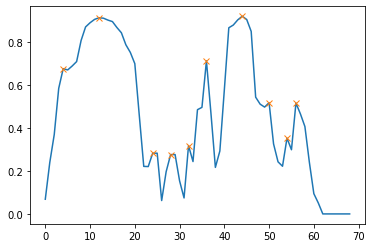

In [394]:
#index = random.randint(0, 48)
index = 27
#print(index)
print(names_array[index])
plt.plot(all1_array[index])
print(all_peaks_array[index])
plt.plot(all_peaks_array[index], all1_array[index][all_peaks_array[index]], 'x')

#print(df_boxes.iloc[index])

In [ ]:
# [STAR] For doing inference of the model

all_target = []
all_scores = []

#device = torch.device("cpu")
#model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt22.pth'))
model.eval()



for images, targets, image_ids in valid_data_loader:
    new_images  = []
    for img in images:
        new_images.append(torch.Tensor(img).to(device))

    images    = new_images
    targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images)
    print(loss_dict)
    
    #print(loss_dict[0]['boxes'].data.cpu().numpy())
    
    all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
    all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())

{'boxes': tensor([ 271, 1057,  805, 1490])}
Ground Truth  [ 271 1057  805 1490] 35
Prediction  [[ 75.71501  283.47375  163.6579   378.79547 ]
 [  4.241309 263.63602   50.325714 373.7304  ]
 [101.045715 287.99136  151.38869  370.79993 ]
 [ 61.922516 258.55548  184.89377  395.74182 ]]
Scores  [0.97706246 0.4141349  0.13911489 0.10131314]
Prediction  [[ 75.71501  283.47375  163.6579   378.79547 ]
 [  4.241309 263.63602   50.325714 373.7304  ]
 [101.045715 287.99136  151.38869  370.79993 ]
 [ 61.922516 258.55548  184.89377  395.74182 ]]
[ 67 264 201 372]


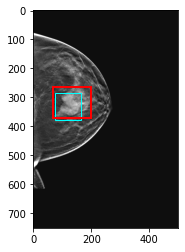

In [257]:
# [STAR] Code to compare the ground truth and predicted mask


case_index   = 35#random.randint(0, len(valid_dataset)-1)
images, b, c = valid_dataset[case_index]
print(b)

print('Ground Truth ', b['boxes'].data.cpu().numpy(), case_index)
print('Prediction ', all_target[case_index])
print('Scores ', all_scores[case_index])

plt.imshow(images[0], cmap='gray')
ax   = plt.gca()

if(len(all_target[case_index]) > 0):    
    temp  = all_target[case_index]
    print('Prediction ', temp)
    index = 0
    rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
    ax.add_patch(rect)
else:
    print('Not found 8')

temp  = b['boxes'].data.cpu().numpy()//4#all_target[index]
index = 0
print(temp)
rect  = patches.Rectangle((temp[0], temp[1]), temp[2]-temp[0], temp[3]-temp[1], linewidth=1, edgecolor='red', fill = False)
ax.add_patch(rect)

plt.show()
case_index = case_index+1